last edited by Claire Valva on September 21, 2018

# Spectral analysis performed on 40.5N data
end of notebook shows average fft magnitude vs. omega
reminders to self: remember zero padding when applying the ifft relationship


##### to do (non urgent/does not affect results): 
edit function which detrends to prevent warnings/for faster code, get rid of repetition in grouping/individual season analysis

##### to do: change windowing?

In [101]:
#set whether or not to reload data, set to true/false
#or use data saved from an old session
do_trends = False #should detrend again?
run_fresh = False #should I reupload file/original data?
save_results = True #should I save the fft results for opening in another notebook?

In [102]:
#import packages
import numpy as np
from scipy.signal import get_window, csd
from scipy.signal.windows import hann, hanning
from scipy.fftpack import fft, ifft, fftfreq, fftshift, ifftshift
import matplotlib.pyplot as plt
import scipy.integrate as sciint
import pandas as pd
import datetime
import matplotlib.cm as cm
from math import pi
import matplotlib.ticker as tck
import datetime
from sympy import solve, Poly, Eq, Function, exp, re, im
from PyEMD import EMD
from netCDF4 import Dataset, num2date # This is to read .nc files and time array
from scipy.optimize import fsolve
import statsmodels.api as sm
from IPython.display import display, Markdown, Latex

In [4]:
#import own functions from functions_forspectralanalysis.py
#functions are based off of those in spectral_analysis_tests.ipynb 
#but edited so that they can be used in multiple notebooks
from functions_forspectralanalysis import *

/home/clairev/python-climate-data-processing/submission_from_claire/40.5N-processing/functions_forspectralanalysis.py:84: RuntimeWarning: divide by zero encountered in true_divide
  zonal_spacing = 1/zonal_spacing


[NbConvertApp] Converting notebook functions_forspectralanalysis.ipynb to script
[NbConvertApp] Writing 5754 bytes to functions_forspectralanalysis.py


## Import and edit file

In [5]:
#import file
filepath = '/home/clairev/uncategorized-data/1979-2016-300hPa-40.5N-z.nc' # Location of the file
fileobj = Dataset(filepath, mode='r')

# Check what's in there
fileobj

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): longitude(240), time(55520)
    variables(dimensions): float32 z(time,longitude)
    groups: 

In [6]:
#set indicies/number of things
number_entries = int(fileobj.dimensions['time'].size)
number_days = int(number_entries / 4)
number_lon = fileobj.dimensions['longitude'].size
year_number = 2016 - 1979 + 1

year_list = [1979 + i for i in range(2016-1979)]

In [7]:
#load coordinates
#so height[i] is the geopotential height at a given time
height = fileobj.variables['z'][:]
g_inv = 1/9.81
height = height*g_inv

In [8]:
#create time array
time_list = []
for i in range(0,55520):
    time_list.append(i*6)
tunit = "hours since 1979-01-01T00:00:00Z"
tarray = num2date(time_list,units = tunit,calendar = 'gregorian')

#create longitude array
lon_increment = 1.5 # The increment of each longitude grid is 1.5
lon_list = [i * lon_increment for i in range(240)]

In [9]:
if run_fresh:

#get lists and then merge together as a dataframe
    lon_list_df = [lon_list[k]
               for i in range(number_entries)
               for k in range(number_lon)]

    z_temp = [height[i][k]
              for i in range(number_entries)
              for k in range(number_lon)]

    date_list = [tarray[i]
               for i in range(number_entries)
               for k in range(number_lon)]
    
    #make this a dataframe
    d = {'datetime' : date_list, 'lon': lon_list_df,
                    'z' : z_temp}
    geopot_df = pd.DataFrame(d)
    
    #get day/month/year separately for groupby
    geopot_df['month'] = geopot_df['datetime'].apply(lambda x: x.month)
    geopot_df['day'] = geopot_df['datetime'].apply(lambda x: x.day)
    geopot_df['year'] = geopot_df['datetime'].apply(lambda x: x.year)
    
    #sort into seasons    
    geopot_df["season"] = geopot_df["month"].apply(lambda x: season_sort(x))
    
    
    # Create storage object with filename `processed_data`
    data_store = pd.HDFStore('processed_data.h5')

    # Put DataFrame into the object setting the key as 'preprocessed_df'
    data_store['preprocessed_geopot'] = geopot_df
    data_store.close()
    
else:
        # Access data store
    data_store = pd.HDFStore('processed_data.h5')

    # Retrieve data using key
    geopot_df = data_store['preprocessed_geopot']
    data_store.close()

## Perform zonal fft

In [10]:
#get fft results at each date over entire longitude
fft_zonal_result = [geopot_fft(height[k]) 
                    for k in range(number_entries)]

In [11]:
#get fft that is zero padding for plotting
fft_zonal_results_zero = [geopot_fft_zero(height[k], length = 372)
                         for k in range(number_entries)]

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


In [12]:
wavenum_zone = fftfreq(372, 1.5)
wavenum_zone = 1/wavenum_zone
wavenum_zone = 372*1.5 / wavenum_zone


/home/clairev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


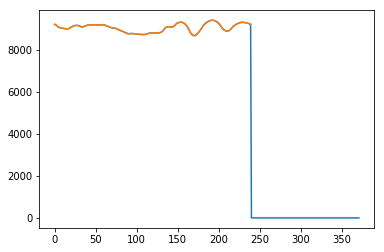

In [13]:
#check if zero padded looks the same as not zero padded
check_zero = ifft(fft_zonal_results_zero[2])
check_norm = ifft(fft_zonal_result[2])

#plot it -- seems like it works or close enough
plt.plot(check_zero)
plt.plot(check_norm)
plt.show()

## Perform time fft

### detrending

detrend all data using results from zonal fft

In [14]:
#get list of years and seasons to perform transform/detrend on
years = range(1979,2017)
seasons = ["winter", "spring", "summer", "fall"]

#### define some functions which depend on the files imported earlier

In [15]:
def trendsfordf(year, season):
    frame = geopot_df.query(query_string(year, season, 9))
    
    trend_list = [pairwavenum(k, frame, tarray, fft_zonal_result) 
                  for k in range(len(zonal_spacing))]
    
    return(trend_list)

##### TO DO: this function gets a lot of runtime warnings, likely from the fsolve - but would be nice to fix later on

In [16]:
def coeff_subtract(time, frame, tarray, fft_zonal_result, trend_list):
    #since gettimes depends on frame, get frame first
    
    #get first and last timestamp
    tmin, tmax = gettimes(frame, tarray)
 
    #get the time steps at the beginning and end of the seasons
    iter_list = time - tmin
    
    #get the results and then subtract the list
    results = fft_zonal_result[time]
    tosub = [sublist[1][iter_list - 1] for sublist in trend_list]
    
    results = results - tosub
    
    return results

In [17]:
def trendsfordf(year, season):
    frame = geopot_df.query(query_string(year, season, 9))
    
    #get trends
    trend_list = [pairwavenum(k, frame, tarray, fft_zonal_result) 
                  for k in range(len(zonal_spacing))]
    
    tmin, tmax = gettimes(frame, tarray)
    
    #adjust the list
    adjusted_list = [coeff_subtract(time, frame, tarray, fft_zonal_result, trend_list) for time in range(tmin, tmax+tmin)]
    
    #perform ifft on the list
    adjusted_list_ifft = [ifft(sublist) for sublist in adjusted_list]
    
    return(season, year, trend_list, adjusted_list, adjusted_list_ifft)

In [18]:
#get the trends in fourier coefficients
if do_trends == True:
    trends_all_list = [trendsfordf(time, season) for season in seasons
                       for time in years]
    
    import pickle

    file_Name = "test_trends_pickle"
    file_pickle = open(file_Name,'wb') 

    pickle.dump(trends_all_list,file_pickle)
    file_pickle.close()

In [19]:
if do_trends == False:
    import pickle
    
    file_Name = "test_trends_pickle"
    
    file_pickle = open(file_Name, "rb")
    
    trends_all_list = pickle.load(file_pickle)

note that the structre of trends_all_list is:

trends = [time, season, trends, adjusted forier coeffs, ifft of adjusted forier coeffs] * 152

where time is a year
season is a season
trends for that time and season are 240 entries of changing trends

In [20]:
#pull everything out of the list
season_index = [sublist[0] for sublist in trends_all_list]
year_index = [sublist[1] for sublist in trends_all_list]
trend_index = [sublist[2] for sublist in trends_all_list]
adjcof_index = [sublist[3] for sublist in trends_all_list]
untrend_index = [sublist[4] for sublist in trends_all_list]

In [21]:
#flatten list of detrended z values
flatten_df_untrend = [item for sublist in untrend_index for item in sublist]
flatten_df_untrend = [item for sublist in flatten_df_untrend for item in sublist]

In [22]:
#get list of same length for df binding - season, year, lon lists
season_df_list = []
year_df_list = []
lon_df_list = []

for i in range(len(untrend_index)):
    for j in range(len(untrend_index[i])):
        for k in range(240):
            entry = season_index[i]
            yr = year_index[i]
            lon = lon_list[k]
            
            season_df_list.append(entry)
            year_df_list.append(yr)
            lon_df_list.append(lon)

In [23]:
d = {"season": season_df_list, "year": year_df_list,
     "lon": lon_df_list, "adj_z": flatten_df_untrend}

untrend_df = pd.DataFrame(d)

### check if the detrending provided results that look sensible

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Figure size 432x288 with 0 Axes>

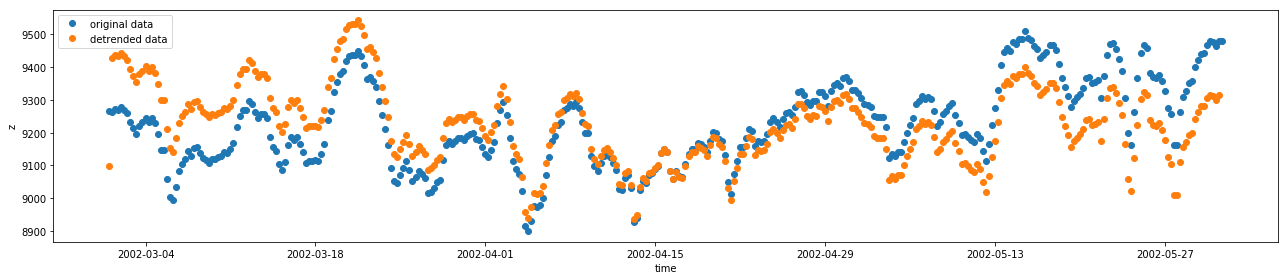

In [24]:
#slice some random part of original dataframe and detrended to see if have similar shape
year_test = 2002
season_test = "spring"

orig_data = geopot_df.query(query_string(year_test, season_test, 9))
untrend_data = untrend_df.query(query_string(year_test, season_test, 9))

#plot the results
#compare them again!
plt.clf();
plt.figure(figsize=(18,4))
plt.plot_date(orig_data["datetime"], orig_data["z"], label = "original data")
plt.plot_date(orig_data["datetime"][:367], untrend_data["adj_z"], label = "detrended data")
plt.xlabel('time')
plt.ylabel('z')
plt.legend()
plt.tight_layout()

### Perform transform on the detrended data
window used in this case is hanning, where the window size is determined by the length of data but everything is zero padded to have the same/maximum length as to not deal with leap years

In [25]:
#choose length of trend that is wanted
#made all the same for easier comparative purposes
want_size = 372

In [26]:
#get spacing
time_spacing_list = fftfreq(want_size, 0.25)
wavenum_time = 1/time_spacing_list
wavenum_time = 93 / wavenum_time

/home/clairev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
def time_fft_window(numbers):
    #gets the time fft with same zero padding for all slices, uses hanning window
    
    num_entries = len(numbers)
    window = hann(num_entries, sym = False)
    fft_for = numbers*window
    fft_coeff = fft(fft_for, n = want_size) 
    fft_withgain = fft_coeff / 0.5
    
    return(fft_withgain)

In [65]:
def time_fft_window_nopad(numbers):
    #gets the time fft with same zero padding for all slices, uses hanning window
    
    num_entries = len(numbers)
    window = hann(num_entries, sym = False)
    fft_for = numbers*window
    fft_coeff = fft(fft_for, n = num_entries) 
    fft_withgain = fft_coeff / 0.5
    
    return(fft_withgain)

In [28]:
def time_fft_nowindow(numbers):
    #gets time fft (same as time_fft_window()) but with no hanning window
    
    num_entries = len(numbers)
    fft_for = numbers
    fft_coeff = fft(fft_for, n = want_size)
    ck_coeff = fft_coeff/want_size
    
    return(fft_coeff)

##### compare results of windowed vs. no window functions and window setting sanity check

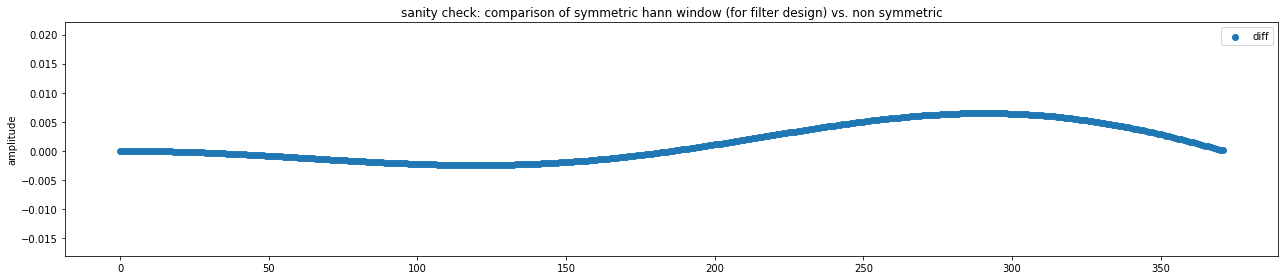

In [68]:
#plot the ifft
proxy_x = list(range(372))

plt.figure(figsize=(18,4))
plt.scatter(proxy_x, hann(372, sym = False) - hann(372, sym = True), label = "diff")
plt.ylabel('amplitude')
plt.legend()
plt.title("sanity check: comparison of symmetric hann window (for filter design) vs. non symmetric")
plt.tight_layout()

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<Figure size 432x288 with 0 Axes>

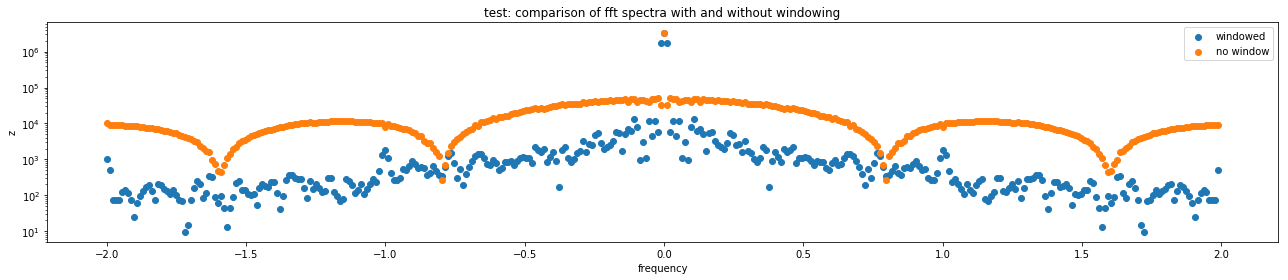

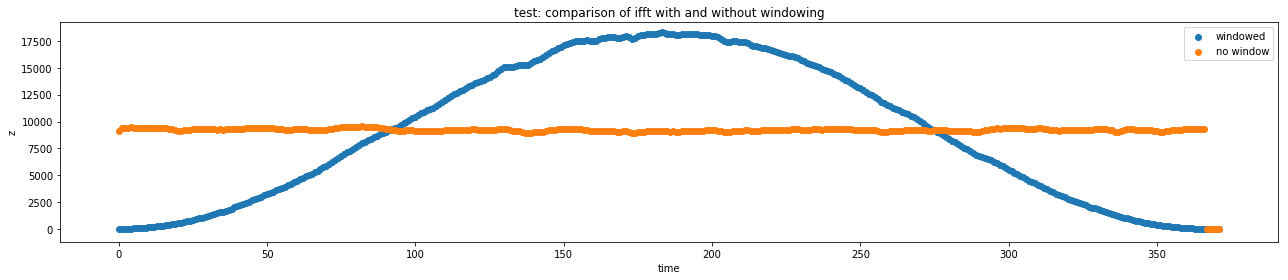

In [30]:
#use same test season as in the detrend sanity check
untrend_data = untrend_df.query(query_string(year_test, season_test, 9))
untrend_data = list(untrend_data["adj_z"])

nowind_test = time_fft_nowindow(untrend_data)
wind_test = time_fft_window(untrend_data)

#plot them with ifft
nowind_ifft_test = ifft(nowind_test)
wind_ifft_test = ifft(wind_test)

#get proxy x for plotting
proxy_freq = fftfreq(372, 0.25)

#plot the spectra
plt.clf();
plt.figure(figsize=(18,4))
plt.scatter(proxy_freq, np.abs(wind_test), label = "windowed")
plt.scatter(proxy_freq, np.abs(nowind_test), label = "no window")
plt.xlabel('frequency')
plt.ylabel('z')
plt.yscale("log")
plt.legend()
plt.title("test: comparison of fft spectra with and without windowing")
plt.tight_layout()

#plot the ifft
plt.figure(figsize=(18,4))
plt.scatter(proxy_x, wind_ifft_test, label = "windowed")
plt.scatter(proxy_x, nowind_ifft_test, label = "no window")
plt.xlabel('time')
plt.ylabel('z')
plt.legend()
plt.title("test: comparison of ifft with and without windowing")
plt.tight_layout()

### Complete the fft

In [31]:
#complete fft
grouped_untrend = untrend_df.groupby(["season","year","lon"])
grouped_z = grouped_untrend["adj_z"]

fft_grouped_wind = grouped_z.apply(time_fft_window) #for actual analysis
fft_grouped_wind_padtest = grouped_z.apply(time_fft_window_nopad) #for 0 padding sanity check
fft_grouped_nowind = grouped_z.apply(time_fft_nowindow) #for no window sanity check 

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


In [32]:
#get indexing of groups
names = grouped_untrend.apply(lambda x: x.name)

In [33]:
def get_ind(match, sublist):
    #function gets indices of the sublist that equal the match term
    toreturn = [j for j in range(len(sublist)) if sublist[j] == match]
    return toreturn

In [34]:
#get list of year/seasons/longitudes
time_fft_seasons = [sublist[0] for sublist in names]
time_fft_year = [sublist[1] for sublist in names]
time_fft_lon = [sublist[2] for sublist in names]

#get lists of indicies
lon_index_time = [get_ind(k, time_fft_lon) for k in lon_list]
season_index_time = [get_ind(match, time_fft_seasons) for match in seasons]
year_index_time = [get_ind(year, time_fft_year) for year in year_list]

In [35]:
def condition_func_wint(i):
    #this function gets the winter indices at longitude index i, not for other seasons bc months in different years 
    results = i in winter_indices 
    return(results)

In [36]:
#want to mean over time, also make sure not to use the first summer
winter_indices, spring_indices, summer_indices, fall_indices = season_index_time

#get matches for winter and longitude, where year != 1979
winter_lon_indices = [[i for i in lon_index_time[j] if condition_func_wint(i)] 
                      for j in range(len(lon_list))]

spring_lon_indices = [[i for i in lon_index_time[j] if i in spring_indices]
                     for j in range(len(lon_list))]

summer_lon_indices = [[i for i in lon_index_time[j] if i in summer_indices]
                     for j in range(len(lon_list))]

fall_lon_indices = [[i for i in lon_index_time[j] if i in fall_indices]
                     for j in range(len(lon_list))]

In [37]:
def get_avglist(indices, valuelist, ax = 0):
    #from indices and the value list, returns the list with the same indices
    toavg = [valuelist[i] for i in indices]
    averaged = np.average(toavg, axis = ax)
    return averaged

In [38]:
#now get the averages of each spectrum for the lists
winter_ffts = [get_avglist(sublist,fft_grouped_wind) for sublist in winter_lon_indices]
spring_ffts = [get_avglist(sublist,fft_grouped_wind) for sublist in spring_lon_indices]
fall_ffts = [get_avglist(sublist,fft_grouped_wind) for sublist in fall_lon_indices]
summer_ffts = [get_avglist(sublist,fft_grouped_wind) for sublist in summer_lon_indices]

#until slight rewrite to make less repetitive
all_ffts = [winter_ffts, spring_ffts, summer_ffts, fall_ffts]

In [39]:
#optionally combine into a full array and pickle so can be used in another doc if needed
if save_results:
    #time fft
    raw_fft_results = [fft_grouped_wind, names]
    
    #zonal_fft
    season_zonal_fft = [[fft_zonal_result[i] for i in range(len(fft_zonal_result)) 
                     if season_sort(tarray[i].month) == label] for label in seasons]
    season_zonal_fft_avg = [np.average(sublist, axis = 0) for sublist in season_zonal_fft]
    total_zonal_fft_avg = np.average(fft_zonal_result, axis = 0)
    
    zonal_fft = [["seasonavg", season_zonal_fft_avg], ["totalavg", total_zonal_fft_avg]]
    
    all_fft_results = [raw_fft_results, zonal_fft]
    
    import pickle
    
    file_Name = "raw_fft_results_sept18"
    
    file_pickle = open(file_Name,'wb') 
    
    pickle.dump(all_fft_results,file_pickle)
    file_pickle.close()

### plot wavenumber vs. fourier coeff

As expected - the highest magnitude of fourier coefficents are in the lower numbers with a peak at about 90/the number of days in all seasons which likely represents daily patterns. The summer curve seems to be the smoothest. In all graphs there also appears to be a peak around f = 15

In [41]:
#flatten lists for plotting
flat_wint_ffts = [item for sublist in winter_ffts for item in sublist]
flat_spring_ffts = [item for sublist in spring_ffts for item in sublist]
flat_fall_ffts = [item for sublist in fall_ffts for item in sublist]
flat_summer_ffts = [item for sublist in summer_ffts for item in sublist]

flat_list_wtime = [wavenum_time for i in range(240)]
flat_list_wtime = [item for sublist in flat_list_wtime for item in sublist]

In [42]:
#set plot ymax
plt_ymax = want_size * 50

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<Figure size 432x288 with 0 Axes>

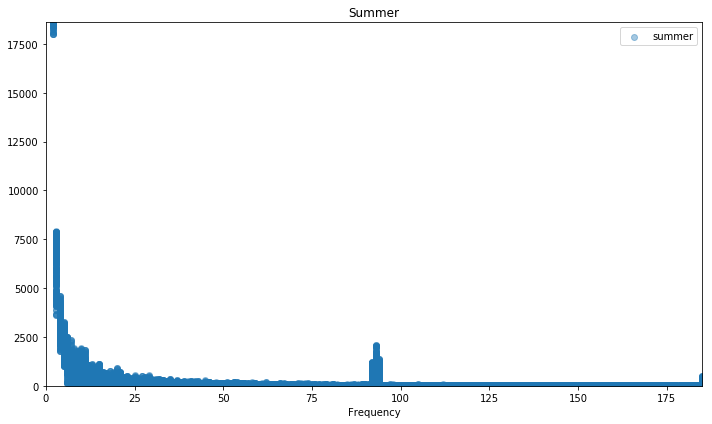

<Figure size 432x288 with 0 Axes>

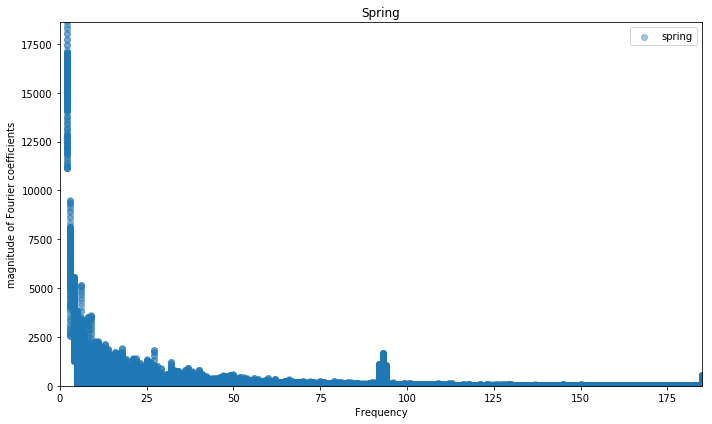

<Figure size 432x288 with 0 Axes>

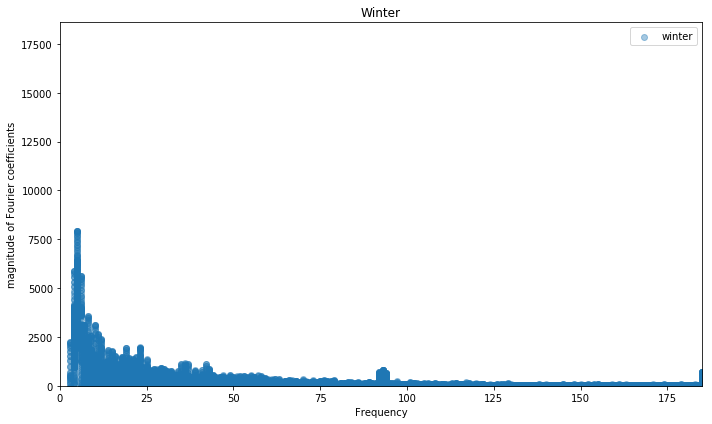

<Figure size 432x288 with 0 Axes>

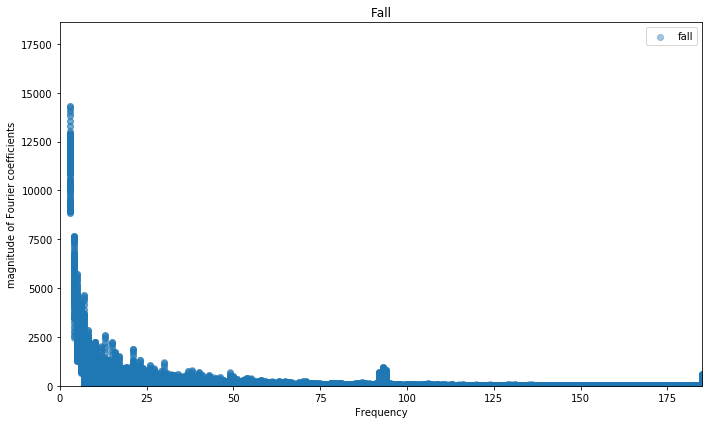

In [43]:
#plot fourier coefficients vs. wavenumber
plt.clf();
plt.figure(figsize=(10,6))
plt.scatter(flat_list_wtime, flat_summer_ffts, label = "summer", alpha = 0.4)
plt.title('Fourier spectrum')
plt.title('Summer')
plt.xlabel('Frequency');
plt.legend()
plt.ylim((0,plt_ymax))
plt.xlim((0,max(flat_list_wtime)))
#plt.yscale("log")
plt.tight_layout()
plt.show()

#plot fourier coefficients vs. wavenumber
plt.clf();
plt.figure(figsize=(10,6))
plt.scatter(flat_list_wtime, flat_spring_ffts, label = "spring", alpha = 0.4)
plt.title('Spring')
plt.xlabel('Frequency');
plt.ylabel('magnitude of Fourier coefficients');
plt.legend()
plt.ylim((0,plt_ymax))
plt.xlim((0,max(flat_list_wtime)))
plt.tight_layout()
plt.show()

#plot fourier coefficients vs. wavenumber
plt.clf();
plt.figure(figsize=(10,6))
plt.scatter(flat_list_wtime, flat_wint_ffts, label = "winter", alpha = 0.4)
plt.title('Winter')
plt.xlabel('Frequency');
plt.ylabel('magnitude of Fourier coefficients');
plt.legend()
plt.ylim((0,plt_ymax))
plt.xlim((0,max(flat_list_wtime)))
plt.tight_layout()
plt.show()

#plot fourier coefficients vs. wavenumber
plt.clf();
plt.figure(figsize=(10,6))
plt.scatter(flat_list_wtime, flat_fall_ffts, label = "fall", alpha = 0.4)
plt.title('Fall')
plt.xlabel('Frequency');
plt.ylabel('magnitude of Fourier coefficients');
plt.legend()
plt.ylim((0,plt_ymax))
plt.xlim((0,max(flat_list_wtime)))
plt.tight_layout()
plt.show()

## Compare shapes of curves

In [44]:
#get loess fits for visualization purposes/comparative - NOT STAT
wint_lowess = sm.nonparametric.lowess(np.abs(np.average(winter_ffts, axis = 0)), wavenum_time, frac = 0.1)
lowess_x = list(zip(*wint_lowess))[0]
wint_lowess_y = list(zip(*wint_lowess))[1]

spring_lowess = sm.nonparametric.lowess(np.abs(np.average(spring_ffts, axis = 0)), wavenum_time, frac = 0.1)
spring_lowess_y = list(zip(*spring_lowess))[1]

summer_lowess = sm.nonparametric.lowess(np.abs(np.average(summer_ffts, axis = 0)), wavenum_time, frac = 0.1)
summer_lowess_y = list(zip(*summer_lowess))[1]

fall_lowess = sm.nonparametric.lowess(np.abs(np.average(fall_ffts, axis = 0)), wavenum_time, frac = 0.1)
fall_lowess_y = list(zip(*fall_lowess))[1]

<Figure size 432x288 with 0 Axes>

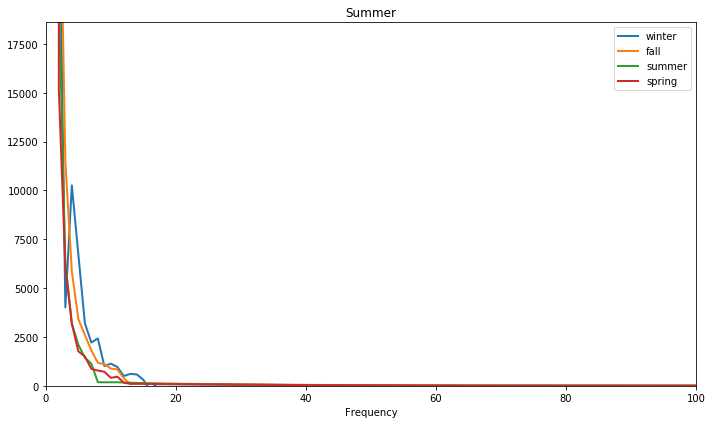

In [45]:
#plot loess
plt.clf();
plt.figure(figsize=(10,6))
plt.plot(lowess_x, wint_lowess_y, linestyle='-', linewidth=2, label = "winter")
plt.plot(lowess_x, fall_lowess_y, linestyle='-', linewidth=2, label = "fall")
plt.plot(lowess_x, summer_lowess_y, linestyle='-', linewidth=2, label = "summer")
plt.plot(lowess_x, spring_lowess_y, linestyle='-', linewidth=2, label = "spring")
plt.title('Fourier spectrum')
plt.title('Summer')
plt.xlabel('Frequency');
plt.legend()
plt.ylim(0,plt_ymax)
plt.xlim((0,100))
plt.tight_layout()
plt.show()

## plot frequency vs. wavenumber
omega/frequency is y axis and k/wavenumber is x axis, should just flatten arrays?

In [46]:
#set lists of longitude sections
lon_1 = 'lon >= 50 & lon <= 140'
lon_2 = 'lon <= 50 | lon >= 320'
lon_3 = 'lon >= 230 & lon <= 320'
lon_4 = 'lon >= 140 & lon <= 230'
lon_labels = [lon_1, lon_2, lon_3, lon_4]

In [47]:
def lon_sort(x):
    #takes a longtude and then returns it ranges number
    
    lon_cond_1 = x >= 50 and x <= 140
    lon_cond_2 = x <= 50 or x >= 320
    lon_cond_3 = x >= 230 and x <= 320
    lon_cond_4 = x >= 140 and x <= 230
    
    conditions = [lon_cond_1, lon_cond_2, lon_cond_3, lon_cond_4]
    
    for i in range(len(conditions)):
        if conditions[i] is True:
            return i
    

In [48]:
#order zonal fft into winter/spring/summer/fall lists and take average
season_zonal_fft = [[fft_zonal_result[i] for i in range(len(fft_zonal_result)) 
                     if season_sort(tarray[i].month) == label] for label in seasons]
season_zonal_fft_avg = [np.average(sublist, axis = 0) for sublist in season_zonal_fft]
total_zonal_fft_avg = np.average(fft_zonal_result, axis = 0)

In [50]:
#do the same except with the extended list
season_zonal_fft_zero = [[fft_zonal_results_zero[i] for i in range(len(fft_zonal_results_zero)) 
                     if season_sort(tarray[i].month) == label] for label in seasons]
season_zonal_fft_avg_zero = [np.average(sublist, axis = 0) for sublist in season_zonal_fft_zero]
total_zonal_fft_avg_zero = np.average(fft_zonal_results_zero, axis = 0)

In [51]:
#get similar averages for the times
time_fft_lon_avg = [[np.average([all_ffts[k][i] for i in range(240) 
                       if lon_sort(lon_list[i]) == j], axis = 0) 
                      for j in range(4)] 
                     for k in range(4)]
time_fft_seas_avg = np.average(all_ffts, axis = 1)
time_total_fft_avg = np.average(fft_grouped_wind, axis = 0)

##### plot average coeff for frequency vs. wavenumber

<Figure size 432x288 with 0 Axes>

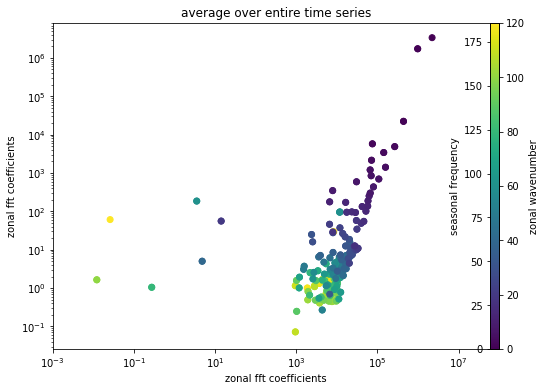

In [52]:
plt.clf();
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
plt.scatter(x = np.abs(total_zonal_fft_avg_zero), y = np.abs(time_total_fft_avg), c = np.abs(wavenum_time))
plt.ylabel("zonal fft coefficients")
plt.xscale("log")
plt.xlim(0.001,100000000)
plt.yscale("log")
plt.xlabel("zonal fft coefficients")
plt.title("average over entire time series")

ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_ylabel("seasonal frequency", labelpad=40)
ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

ax2.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelright=False)

cbar = plt.colorbar()
pos = cbar.ax.get_position()
cbar.ax.set_aspect('auto')

# create a second axes instance and set the limits you need
ax2 = cbar.ax.twinx()
ax2.set_ylim(min(np.abs(zonal_spacing)), max((np.abs(zonal_spacing))))

# resize the colorbar (otherwise it overlays the plot)
pos.x0 +=0.1
cbar.ax.set_position(pos)
ax2.set_position(pos)
ax2.set_ylabel("zonal wavenumber")


plt.show()

##### same plot as above, but cropped with no log scale

<Figure size 432x288 with 0 Axes>

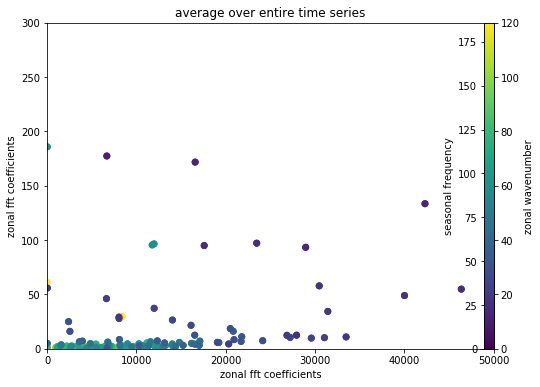

In [53]:
plt.clf();
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
plt.scatter(x = np.abs(total_zonal_fft_avg_zero), y = np.abs(time_total_fft_avg), c = np.abs(wavenum_time))
plt.ylabel("zonal fft coefficients")
plt.xlim(0,50000)
plt.ylim(0,300)
plt.xlabel("zonal fft coefficients")
plt.title("average over entire time series")

ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_ylabel("seasonal frequency", labelpad=40)
ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

ax2.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelright=False)

cbar = plt.colorbar()
pos = cbar.ax.get_position()
cbar.ax.set_aspect('auto')

# create a second axes instance and set the limits you need
ax2 = cbar.ax.twinx()
ax2.set_ylim(min(np.abs(zonal_spacing)), max((np.abs(zonal_spacing))))

# resize the colorbar (otherwise it overlays the plot)
pos.x0 +=0.1
cbar.ax.set_position(pos)
ax2.set_position(pos)
ax2.set_ylabel("zonal wavenumber")


plt.show()

### frequency vs. wavenumber by seasons

<Figure size 432x288 with 0 Axes>

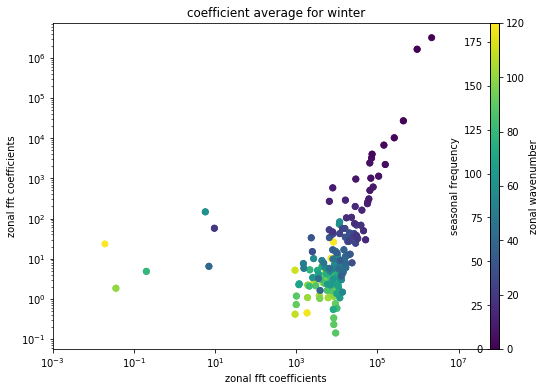

<Figure size 432x288 with 0 Axes>

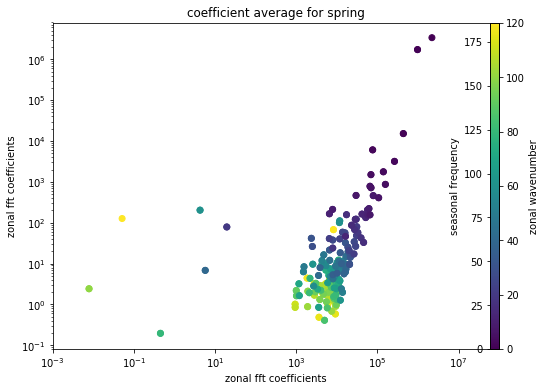

<Figure size 432x288 with 0 Axes>

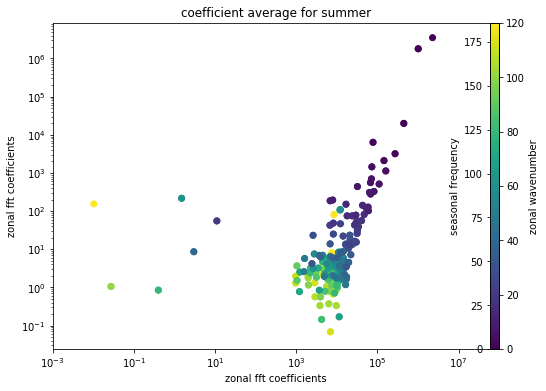

<Figure size 432x288 with 0 Axes>

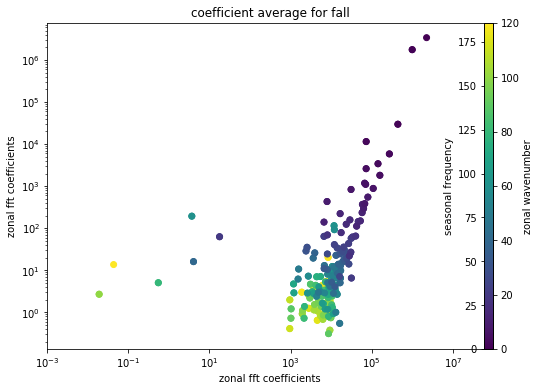

In [54]:
for i in range(4):
    plt.clf();
    fig1 = plt.figure(figsize=(8,6))
    ax1 = fig1.add_subplot(111)
    plt.scatter(y = np.abs(time_fft_seas_avg[i]), x = np.abs(season_zonal_fft_avg_zero[i]),  c = np.abs(wavenum_time))
    plt.ylabel("zonal fft coefficients")
    plt.xscale("log")
    plt.xlim(0.001,100000000)
    plt.yscale("log")
    plt.xlabel("zonal fft coefficients")
    plt.title("coefficient average for " + seasons[i])

    ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    ax2.set_ylabel("seasonal frequency", labelpad=40)
    ax2.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)

    ax2.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelright=False)

    cbar = plt.colorbar()
    pos = cbar.ax.get_position()
    cbar.ax.set_aspect('auto')

    # create a second axes instance and set the limits you need
    ax2 = cbar.ax.twinx()
    ax2.set_ylim(min(np.abs(zonal_spacing)), max((np.abs(zonal_spacing))))

    # resize the colorbar (otherwise it overlays the plot)
    pos.x0 +=0.1
    cbar.ax.set_position(pos)
    ax2.set_position(pos)
    ax2.set_ylabel("zonal wavenumber")


    plt.show()

### Plot wavenumber/frequency as a histogram

In [55]:
#get points for plotting total averages
total_for_histo_time = [wavenum_time[i] for i in range(len(wavenum_time)) 
                   for j in range(int(np.around(np.abs(time_total_fft_avg[i]))))]

total_for_histo_zone = [wavenum_zone[i] for i in range(len(wavenum_zone)) 
                   for j in range(int(np.around(np.abs(total_zonal_fft_avg_zero[i]))))]

In [56]:
#get points for plotting seasonal averages
seasons_for_histo_time = [[wavenum_time[i] for i in range(len(wavenum_time)) 
                   for j in range(int(np.around(np.abs(time_fft_seas_avg[k][i]))))]
                         for k in range(len(seasons))]

seasons_for_histo_zone = [[wavenum_zone[i] for i in range(len(zonal_spacing)) 
                   for j in range(int(np.around(np.abs(season_zonal_fft_avg[k][i]))))]
                         for k in range(len(seasons))]

seasons_for_histo_zone_zero = [[wavenum_zone[i] for i in range(len(wavenum_zone)) 
                   for j in range(int(np.around(np.abs(season_zonal_fft_avg_zero[k][i]))))]
                         for k in range(len(seasons))]

In [57]:
#get points for plotting histogram to compare between longitude bands 
seasons_lon_time_hist = [[[wavenum_time[i] for i in range(len(wavenum_time)) 
                   for j in range(int(np.around(np.abs(time_fft_lon_avg[k][h][i]))))]
                         for h in range(4)]
                         for k in range(len(seasons))]

#### histogram: total average

<Figure size 432x288 with 0 Axes>

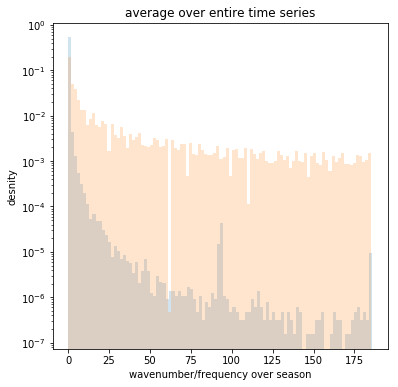

In [58]:
plt.clf()
plt.clf();
plt.figure(figsize=(6,6))
plt.hist(np.abs(total_for_histo_time), bins = 100, log = True, alpha = 0.2, density = True)
plt.hist(np.abs(total_for_histo_zone), bins = 100, log = True, alpha = 0.2, density = True)
plt.ylabel("desnity")
plt.xlabel("wavenumber/frequency over season")
plt.title("average over entire time series")
plt.show()

#### histogram: seasonal average

<Figure size 432x288 with 0 Axes>

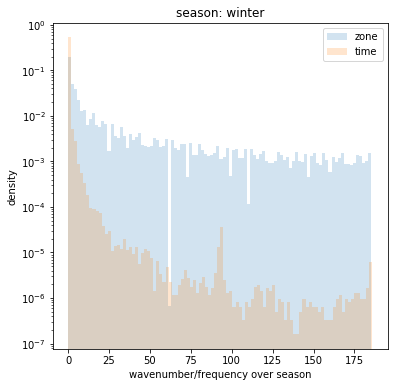

<Figure size 432x288 with 0 Axes>

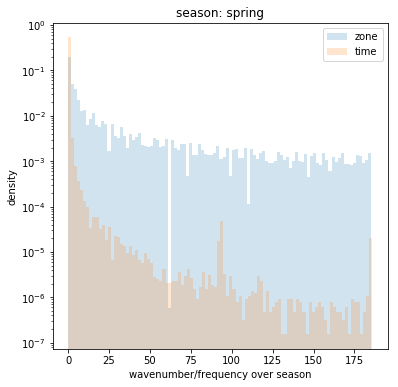

<Figure size 432x288 with 0 Axes>

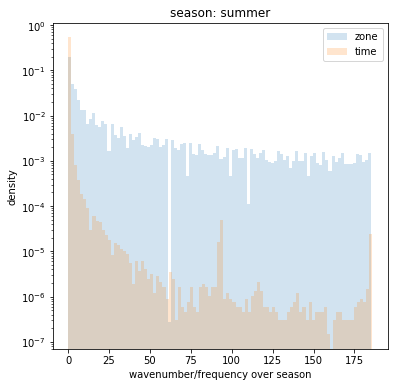

<Figure size 432x288 with 0 Axes>

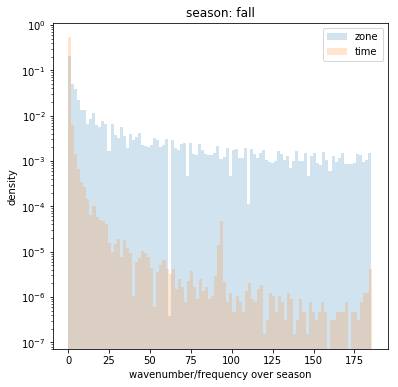

In [59]:
for i in range(4):
    plt.clf()
    plt.figure(figsize=(6,6))
    plt.hist(np.abs(seasons_for_histo_zone_zero[i]), bins = 100, log = True, alpha = 0.2, 
             label = "zone",density = True)
    plt.hist(np.abs(seasons_for_histo_time[i]), bins = 100, log = True, alpha = 0.2, 
             label = "time", density = True)
    plt.ylabel("density")
    plt.xlabel("wavenumber/frequency over season")
    plt.title("season: " + str(seasons[i]))
    plt.legend()
    plt.show()

#### histogram: comparison of fourier coeffs for seasonal/longitude bands

#### season: winter

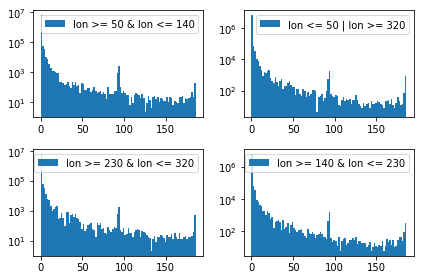

#### season: spring

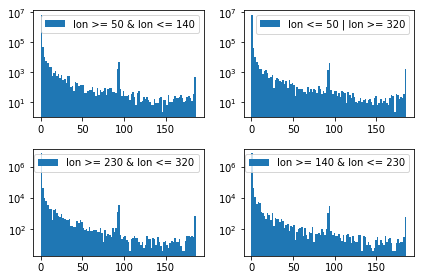

#### season: summer

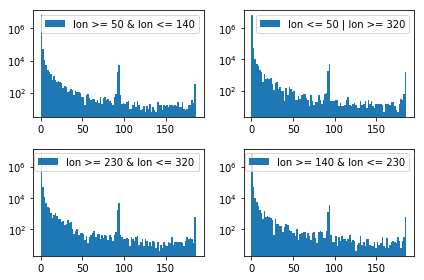

#### season: fall

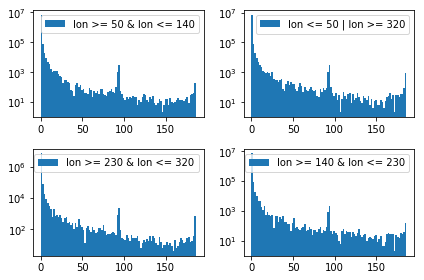

In [60]:
for i in range(4):
    
    display(Markdown('#### season: ' + str(seasons[i])))
    
    plt.clf()
    
    for j in range(4):
        plt.subplot(2,2,1 + j)
        plt.hist(np.abs(seasons_lon_time_hist[i][j]), label = lon_labels[j], 
             bins = 100, log = True)
        plt.legend()
    
    
    plt.tight_layout()
    plt.show()

## Sanity check: zero padding and fft averages

In [80]:
#do the same for spring - to sanity check for whether padding works or not
spring_ffts_nopad = [get_avglist(sublist,fft_grouped_wind_padtest) for sublist in spring_lon_indices]

#get spring no padding average as well
spring_nopad_fft_avg = np.average(spring_ffts_nopad, axis = 0)

In [89]:
#get points for plotting seasonal averages
no_padwavenum = fftfreq(len(spring_nopad_fft_avg), 0.25)
no_padwavenum  = 1/no_padwavenum 
days = 367/4
no_padwavenum  = days /no_padwavenum 

spring_for_histo_time_nopad = [no_padwavenum[i] for i in range(len(no_padwavenum))
                               for j in range(int(np.around(np.abs(spring_nopad_fft_avg[i]))))]

/home/clairev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 432x288 with 0 Axes>

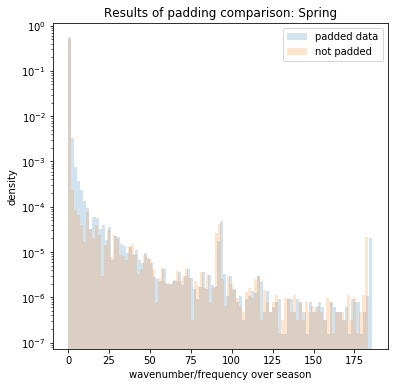

In [97]:
#first plot what fft averages look like when compared
plt.clf()
plt.figure(figsize=(6,6))
plt.hist(np.abs(seasons_for_histo_time[1]), bins = 100, log = True, alpha = 0.2, 
             label = "padded data",density = True)
plt.hist(np.abs(spring_for_histo_time_nopad), bins = 100, log = True, alpha = 0.2, 
             label = "not padded", density = True)
plt.ylabel("density")
plt.xlabel("wavenumber/frequency over season")
plt.title("Results of padding comparison: Spring")
plt.legend()
plt.show()

While these are not identical, they look similar/look like they have an offset - which makes sense as the data points are of different lengths, a better test would be to see if the ifft looks the same

In [96]:
#use ifft
spring_ifft_pad = ifft(time_fft_seas_avg[1])
spring_ifft_nopad = ifft(spring_nopad_fft_avg)

#get proxy x for plotting
proxyx_pad = list(range(len(spring_ifft_pad)))
proxyx_nopad = list(range(len(spring_ifft_nopad)))

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<Figure size 432x288 with 0 Axes>

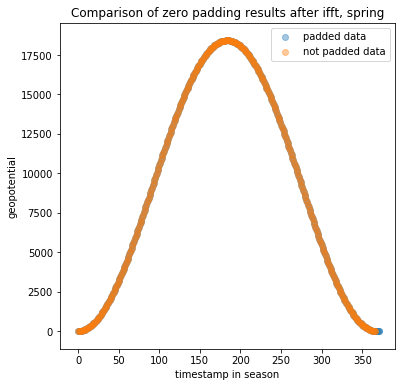

In [100]:
#first plot what fft averages look like when compared
plt.clf()
plt.figure(figsize=(6,6))
plt.scatter(x = proxyx_pad, y = spring_ifft_pad, label = "padded data", alpha = 0.4)
plt.scatter(x = proxyx_nopad, y = spring_ifft_nopad, label = "not padded data", alpha = 0.4)
plt.ylabel("geopotential")
plt.xlabel("timestamp in season")
plt.title("Comparison of zero padding results after ifft, spring")
plt.legend()
plt.show()

These look the same, the padded data is just longer, so no effect (which was the expected result). 

## Test/sanity check: adjust FFT for coherent gain

The hanning window leads to a loss of energy, so one can scale if back (if needed) by dividing the fourier coefficients by the coherent gain, which is defined as: $\int_0^1 \frac{1 - cos(2\pi x / N){2} dx = 0.5$

from https://www.wavemetrics.net/doc/igorman/III-09%20Signal%20Processing.pdf and
The-practicing-instrumentation-engineers-guide-to-the-DFT---Part-2--Spectral-leakage-and-windowing.pdf

In [61]:
coherent_gain_fact = 0.5

#### to check this, try sanity check again

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<Figure size 432x288 with 0 Axes>

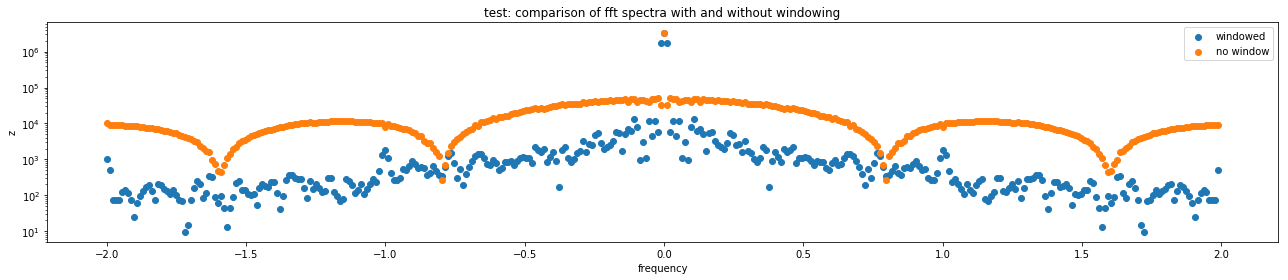

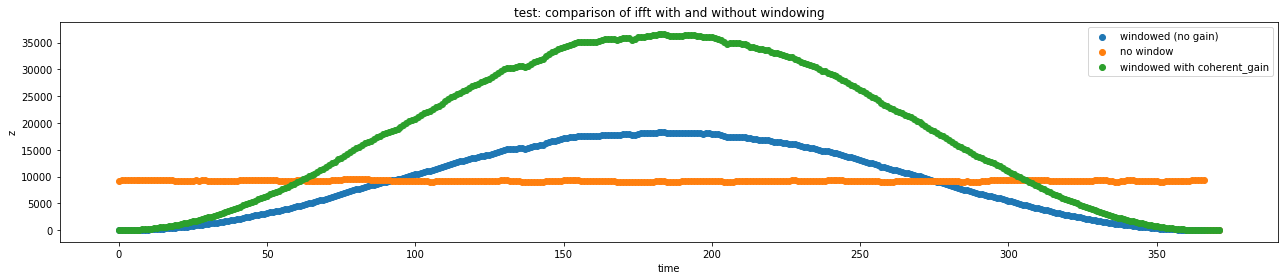

In [70]:
#use same test season as in the detrend sanity check
untrend_data = untrend_df.query(query_string(year_test, season_test, 9))
untrend_data = list(untrend_data["adj_z"])

nowind_test = time_fft_nowindow(untrend_data)
wind_test = time_fft_window(untrend_data)

#plot them with ifft
nowind_ifft_test = ifft(nowind_test)
wind_ifft_test = ifft(wind_test)
wint_withgain_test = ifft(wind_test / coherent_gain_fact )

#get proxy x for plotting
proxy_freq = fftfreq(372, 0.25)

#plot the spectra
plt.clf();
plt.figure(figsize=(18,4))
plt.scatter(proxy_freq, np.abs(wind_test), label = "windowed")
plt.scatter(proxy_freq, np.abs(nowind_test), label = "no window")
plt.xlabel('frequency')
plt.ylabel('z')
plt.yscale("log")
plt.legend()
plt.title("test: comparison of fft spectra with and without windowing")
plt.tight_layout()

#plot the ifft
plt.figure(figsize=(18,4))
plt.scatter(proxy_x, wind_ifft_test, label = "windowed (no gain)")
plt.scatter(proxy_x, nowind_ifft_test, label = "no window")
plt.scatter(proxy_x, wint_withgain_test, label = "windowed with coherent_gain")

plt.xlabel('time')
plt.ylabel('z')
plt.legend()
plt.title("test: comparison of ifft with and without windowing")
plt.tight_layout()